In [1]:
from nltk.corpus.reader.wordnet import Lemma
import nltk
nltk.download('all')

# For file reading
import os
from os import listdir
# For pre-processing 
from nltk import word_tokenize
from nltk.tokenize import punkt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re
import pandas as pd
import numpy as np
import string
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# 5-fold cross validation (CV)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [2]:
def read_data(path: str) -> list:
    """ Read files from a directory and then append the data of each file into a list. """
    folder = listdir(path)
    res = []
    for files in folder:
        # check if current path is a file
        if files != "README.txt":
            filePath = os.path.join(path, files)
            if os.path.isfile(filePath):
                with open(filePath, "r") as file:
                    lines = file.readlines()
                res.append(lines)
    return res

def get_raw_data(res: list) -> list:
    '''Get avaliable data for training and testing data'''
    # Getting avaliable data for LSTM
    avaliable_data = []
    for document in res:
        # Remove \n from the string list
        processedList = [s.strip() for s in document]
        # Remove [t] tag
        processedList = [re.sub('\[t\]', '', word) for word in processedList]
        # Store values in list
        for sentence in processedList:
            # Remove non-tagged data and empty data
            if (not sentence.startswith("##")) and (sentence != ""):
                avaliable_data.append(sentence)
                
    # Store raw review and raw sentiment seperatly in 2 lists
    raw_tag = []
    raw_text = []
    
    for data in avaliable_data:
        # Split data into tag and text
        split_data = data.split("##")

        left_tag = split_data[0]
        right_text = split_data[-1]

        # Get pre-defined sentiment tags, with or without +/-
        num_list = re.findall(r'[+|-]+\d+', left_tag)
        num_only = re.findall(r'\[\d+\]', left_tag)

        new_num_only = [num.replace('[', '') for num in num_only]
        new_num_only = [num.replace(']', '') for num in new_num_only]
        num_list = num_list +  new_num_only
        
        raw_tag.append(num_list)
        raw_text.append(right_text)
    
    return raw_tag, raw_text

def preprocess_text(s: str) -> list:
    '''Text cleaning and pre-processing'''
    # Remove number
    s = re.sub(r'\d+', ' ', s)
    pattern = r'''(?x)        # set flag to allow verbose regexps
                    (?:[A-Z]\.)+      #abbreviations, e.g. 
                    |\[
                    |\w+\'+\w+        #keep contractions, e.g. doesn't 
                    |[^\w\s]
                    |\#
                    |[-.(]+           #double hyphen, ellipsis, open parenthesis
                    |\S\w*
                    |\$?\d+(?:\.\d+)?%? #currency and percentages
        '''
    # Tokenization
    token_list = nltk.regexp_tokenize(s, pattern)
    #To lower case
    token_list = [word.lower() for word in token_list]
    #Remove stopwords
    stopW = stopwords.words("english")
    stopW.append("mp")
    stopW.append("i'm")
    stopW.append("i've")
    token_list = list(filter(lambda word: word not in stopW,token_list))
    #Remove Punctuation
    token_list = list(filter(lambda word: punkt.PunktToken(word).is_non_punct,token_list))
    # Lemmatization 
    lemma = WordNetLemmatizer()
    token_list = [lemma.lemmatize(word) for word in token_list]
    
    return token_list

def get_review_label(raw_tag: list, raw_text: list):
    '''Pre-process the reviews and encoding the label'''
    reviews = []
    for text in raw_text:
        review = preprocess_text(text)
        reviews.append(review)
    sentiments = []
    for review in raw_tag:
        total = 0
        tag_size = len(review)
        # Add all the positive and negative tag together to check if the whole review is positive or negative
        if tag_size >= 1:
            for num in review:
                total += int(num)
        
        # Encoded the labels
        if total > 0:
            sentiments.append(1)
        else:
            sentiments.append(0)
    return sentiments, reviews


def get_encoded_reviews(reviews: list):
    '''Encoding all the words with their frquency'''
    # Get word frequency in all reviews
    all_word = []
    for sen in reviews:
        all_word+=sen

    word_freq = nltk.FreqDist(all_word)

    # Encode the reviews
    encoded_review = []
    for sen in reviews:
        encode_list = list(word_freq[word] for word in sen)
        encoded_review.append(encode_list)
    
    return encoded_review


def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [3]:
path = "/content/product_reviews"

# Reading documents
res = read_data(path)
raw_tag, raw_text = get_raw_data(res)
labels, texts = get_review_label(raw_tag, raw_text)
data = []
for i in range(len(labels)):
    data.append([texts[i], labels[i]])
    
# Create the dataframe for training and testing data
df = pd.DataFrame(data, columns=["Reviews", "Sentiments"])
encoded_reviews = get_encoded_reviews(texts)

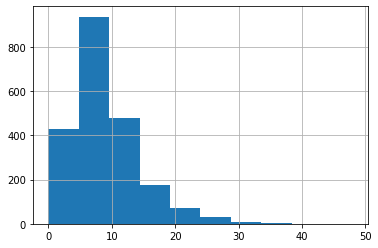

count    2138.000000
mean        8.902713
std         5.399257
min         0.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        48.000000
dtype: float64

In [4]:
reviews_len = [len(x) for x in encoded_reviews]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [5]:
# As most of the review size is below 30, set the sequence length to 30
sequence_len = 30
features = pad_features(encoded_reviews, sequence_len)
print("features:   \n",features)
print("features len:   ",len(features))
print("features[0] len/ Vocab len:   ",len(features[0]))

features:   
 [[  0   0   0 ...  25   6  19]
 [  0   0   0 ...  19   1   6]
 [  0   0   0 ...  27  62  16]
 ...
 [  0   0   0 ...  11 137   1]
 [  0   0   0 ...  21   8  11]
 [  0   0   0 ...  21 154   1]]
features len:    2138
features[0] len/ Vocab len:    30


In [14]:
# split data into 75% of training data and 25 % of testing data
texts_train, texts_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25)

# # define 5-fold cross validation test harness
# kf = KFold(n_splits=5)

# for train_index, test_index in kf.split(features):
#     texts_train, texts_test = features[train_index], features[test_index]
#     labels_train, labels_test = labels[train_index], labels[test_index]

In [15]:
# print(len(texts_train), len(texts_test), len(labels_train), len(labels_test)
print(texts_train[:50])
print(labels_train[:50])

[[  0   0   0 ... 190 104   1]
 [  0   0   0 ...  35   3  25]
 [  0   0   0 ... 154  13   5]
 ...
 [  0   0   0 ... 190   8 119]
 [  0   0   0 ...  12 108  17]
 [  0   0   0 ...  12  33  15]]
[0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1
 1 1 1 1 0 1 1 0 1 1 1 1 0]


# Define the LSTM Model

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Model

In [35]:
model = Sequential()
# add an embedding layer which will convert each word into a dense vector of embedding dimensions
embedding_dim = 256
vocab_size = len(encoded_reviews)+1 # +1 for the 0 padding
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_len))
# specify the Bidirectional() layer and the LSTM layer with a specified unit size in the LSTM layer
lstm_out = 1
model.add(Bidirectional(LSTM(lstm_out)))
# specify a fully connected layer having 10 units and ‘relu’ activation
model.add(Dense(10, activation='relu'))
# add an output layer having only 1 unit and ‘sigmoid’ activation, 
# output the probability that an input belongs to 1 (or positive) using the sigmoid filter.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# visualization of LSTM model
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 256)           547584    
                                                                 
 bidirectional_4 (Bidirectio  (None, 2)                2064      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 10)                30        
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 549,689
Trainable params: 549,689
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# specify the callback for EarlyStopping(), which will halt the model training after the model fails to 
# minimize the validation loss value after the stated no. of epochs in the callback parameters.
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

Train the model

In [37]:
# fit our model on the training data for a maximum of 70 epochs
batch_size=200
history = model.fit(texts_train, labels_train, validation_data=(texts_test, labels_test), epochs=70, batch_size=batch_size, callbacks=callbacks)

Epoch 1/70
8/9 [=========================>....] - ETA: 0s - loss: 0.6809 - accuracy: 0.6300

9/9 [==============================] - 20s 2s/step - loss: 0.6799 - accuracy: 0.6289 - val_loss: 0.6624 - val_accuracy: 0.6253
Epoch 2/70
8/9 [=========================>....] - ETA: 0s - loss: 0.6573 - accuracy: 0.6244

9/9 [==============================] - 16s 2s/step - loss: 0.6546 - accuracy: 0.6295 - val_loss: 0.6553 - val_accuracy: 0.6253
Epoch 3/70
8/9 [=========================>....] - ETA: 0s - loss: 0.6477 - accuracy: 0.6294

9/9 [==============================] - 16s 2s/step - loss: 0.6478 - accuracy: 0.6295 - val_loss: 0.6517 - val_accuracy: 0.6230
Epoch 4/70
8/9 [=========================>....] - ETA: 0s - loss: 0.6358 - accuracy: 0.6344

9/9 [==============================] - 15s 2s/step - loss: 0.6380 - accuracy: 0.6306 - val_loss: 0.6462 - val_accuracy: 0.6300
Epoch 5/70
8/9 [=========================>....] - ETA: 0s - loss: 0.6300 - accuracy: 0.6413

9/9 [==============================] - 16s 2s/step - loss: 0.6276 - accuracy: 0.6458 - val_loss: 0.6433 - val_accuracy: 0.6276
Epoch 6/70
8/9 [=========================>....] - ETA: 0s - loss: 0.6185 - accuracy: 0.6544

9/9 [==============================] - 17s 2s/step - loss: 0.6171 - accuracy: 0.6563 - val_loss: 0.6380 - val_accuracy: 0.6323
Epoch 7/70
8/9 [=========================>....] - ETA: 0s - loss: 0.6078 - accuracy: 0.6550

9/9 [==============================] - 15s 2s/step - loss: 0.6080 - accuracy: 0.6540 - val_loss: 0.6345 - val_accuracy: 0.6347
Epoch 8/70
8/9 [=========================>....] - ETA: 0s - loss: 0.5983 - accuracy: 0.6700

9/9 [==============================] - 16s 2s/step - loss: 0.5986 - accuracy: 0.6698 - val_loss: 0.6321 - val_accuracy: 0.6347
Epoch 9/70
8/9 [=========================>....] - ETA: 0s - loss: 0.5902 - accuracy: 0.6869

9/9 [==============================] - 16s 2s/step - loss: 0.5900 - accuracy: 0.6832 - val_loss: 0.6312 - val_accuracy: 0.6347
Epoch 10/70
8/9 [=========================>....] - ETA: 0s - loss: 0.5823 - accuracy: 0.6856

9/9 [==============================] - 15s 2s/step - loss: 0.5829 - accuracy: 0.6844 - val_loss: 0.6285 - val_accuracy: 0.6370
Epoch 11/70
8/9 [=========================>....] - ETA: 0s - loss: 0.5780 - accuracy: 0.7031

9/9 [==============================] - 16s 2s/step - loss: 0.5765 - accuracy: 0.7043 - val_loss: 0.6278 - val_accuracy: 0.6347
Epoch 12/70
8/9 [=========================>....] - ETA: 0s - loss: 0.5665 - accuracy: 0.7075

9/9 [==============================] - 16s 2s/step - loss: 0.5678 - accuracy: 0.7066 - val_loss: 0.6267 - val_accuracy: 0.6276
Epoch 13/70
8/9 [=========================>....] - ETA: 0s - loss: 0.5650 - accuracy: 0.7044

9/9 [==============================] - 15s 2s/step - loss: 0.5611 - accuracy: 0.7089 - val_loss: 0.6260 - val_accuracy: 0.6300
Epoch 14/70
9/9 [==============================] - 1s 65ms/step - loss: 0.5529 - accuracy: 0.7200 - val_loss: 0.6285 - val_accuracy: 0.6253
Epoch 15/70
9/9 [==============================] - 1s 68ms/step - loss: 0.5484 - accuracy: 0.7136 - val_loss: 0.6264 - val_accuracy: 0.6393


In [38]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

        loss  accuracy  val_loss  val_accuracy
0   0.679950  0.628872  0.662402      0.625293
1   0.654557  0.629456  0.655259      0.625293
2   0.647758  0.629456  0.651699      0.622951
3   0.637973  0.630625  0.646239      0.629977
4   0.627615  0.645821  0.643320      0.627635
5   0.617059  0.656341  0.637964      0.632318
6   0.608039  0.654004  0.634468      0.634660
7   0.598615  0.669784  0.632124      0.634660
8   0.589962  0.683226  0.631158      0.634660
9   0.582916  0.684395  0.628516      0.637002
10  0.576467  0.704266  0.627769      0.634660
11  0.567829  0.706604  0.626718      0.627635
12  0.561136  0.708942  0.625995      0.629977
13  0.552934  0.720047  0.628493      0.625293
14  0.548396  0.713618  0.626448      0.639344


Testing Model

In [39]:
# Testing with 5 fold cross validation
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(features):
    texts_train, texts_test = features[train_index], features[test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]

score,acc = model.evaluate(texts_test, labels_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

3/3 - 0s - loss: 0.6264 - accuracy: 0.6393 - 59ms/epoch - 20ms/step
score: 0.63
acc: 0.64
